In [ ]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [ ]:
!pip install -q keras-tuner

In [ ]:
%cd /content/drive/MyDrive/SkimLit_NPL

/content/drive/MyDrive/SkimLit_NPL


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime
import os
import keras
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
import random
from tensorflow.keras.layers import Input, Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D,Dense, BatchNormalization, Dropout, Concatenate
import tensorflow_hub as hub
from keras.utils import plot_model
import keras_tuner as kt

In [ ]:
# Recording experiments performed
experiments = {"Experiments": [0, 1, 2, 3, 4],
            "Model": ["MultinomialNB (baseline model", "Conv1D with token embeddings", "Using Feature extraction with pretrained token embeddings",
                      "Conv1D with character embeddings", "Combining pretrained token embeddings + characters embeddings",
                      ]}
experiments = pd.DataFrame(experiments)
experiments

,Experiments,Model
0,0,MultinomialNB (baseline model
1,1,Conv1D with token embeddings
2,2,Using Feature extraction with pretrained token...
3,3,Conv1D with character embeddings
4,4,Combining pretrained token embeddings + charac...


#1. Preprocessing data



##1.1 Download data

We will the PubMed 200k RCT dataset by link: https://arxiv.org/abs/1710.06071

In [ ]:
# #Download data from authors github
# !git clone https://github.com/Franck-Dernoncourt/pubmed-rct

In [ ]:
!ls

logs  pubmed-rct


In [ ]:
%cd pubmed-rct

/content/drive/MyDrive/SkimLit_NPL/pubmed-rct


In [ ]:
!ls

checkpoints  models					    pubmed-rct
logs	     PubMed_200k_RCT				    README.md
model_5      PubMed_200k_RCT_numbers_replaced_with_at_sign  train.txt
model_5.h5   PubMed_20k_RCT				    train.zip
model.png    PubMed_20k_RCT_numbers_replaced_with_at_sign   untitled_project


We will use PubMed 20k to build the model and experiment on it. Then we upscale to 200k dataset

In [ ]:
!ls PubMed_20k_RCT_numbers_replaced_with_at_sign
!ls PubMed_20k_RCT

dev.txt  test.txt  train.txt
dev.txt  test.txt  train.txt


In [ ]:
!ls PubMed_200k_RCT_numbers_replaced_with_at_sign
!ls PubMed_200k_RCT

dev.txt  test.txt  train.txt
dev.txt  test.txt  train.7z


In [ ]:
# !unzip /content/drive/MyDrive/SkimLit_NPL/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip -d "/content/drive/MyDrive/SkimLit_NPL/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign"

In [ ]:
!ls PubMed_200k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [ ]:
data_dir = "/content/drive/MyDrive/SkimLit_NPL/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/" 

In [ ]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/drive/MyDrive/SkimLit_NPL/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/drive/MyDrive/SkimLit_NPL/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/drive/MyDrive/SkimLit_NPL/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/test.txt']

##1.2 Explore data analysis

In [ ]:
# Create a function to read the lines of the documents
def get_lines(filename):

  with open(filename, "r") as f:
    list_line =  f.readlines()

  return list_line

In [ ]:
train_lines = get_lines(filenames[0])
train_lines[:20]

['###24491034\n',
 'BACKGROUND\tThe emergence of HIV as a chronic condition means that people living with HIV are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .\n',
 'BACKGROUND\tThis paper describes the design and evaluation of Positive Outlook , an online program aiming to enhance the self-management skills of gay men living with HIV .\n',
 'METHODS\tThis study is designed as a randomised controlled trial in which men living with HIV in Australia will be assigned to either an intervention group or usual care control group .\n',
 "METHODS\tThe intervention group will participate in the online group program ` Positive Outlook ' .\n",
 'METHODS\tThe program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with HIV in daily life .\n',
 'METHODS\tParticipants will access the program f

In [ ]:
len(train_lines)

2593169

In [ ]:
# Create a function returns a list of dictionaries of abstract line data
def preprocess_text_with_line_numbers(filename):

  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  # Loop through each line in the input
  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""

    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["line_number"] = abstract_line_number
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["total_lines"] = len(abstract_line_split) - 1 # start from 0
        abstract_samples.append(line_data)

    else:
      abstract_lines += line

  return abstract_samples

In [ ]:
train_lines[1]

'BACKGROUND\tThe emergence of HIV as a chronic condition means that people living with HIV are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .\n'

In [ ]:
pwd

'/content/drive/MyDrive/SkimLit_NPL/pubmed-rct'

In [ ]:
%%time
train_samples = preprocess_text_with_line_numbers(filenames[0])
val_samples = preprocess_text_with_line_numbers(filenames[1])
test_samples = preprocess_text_with_line_numbers(filenames[2])
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 7.06 s, sys: 2.62 s, total: 9.68 s
Wall time: 25.5 s


(2211861, 28932, 29493)

In [ ]:
train_samples[:13]

[{'line_number': 0,
  'target': 'BACKGROUND',
  'text': 'the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
  'total_lines': 10},
 {'line_number': 1,
  'target': 'BACKGROUND',
  'text': 'this paper describes the design and evaluation of positive outlook , an online program aiming to enhance the self-management skills of gay men living with hiv .',
  'total_lines': 10},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'this study is designed as a randomised controlled trial in which men living with hiv in australia will be assigned to either an intervention group or usual care control group .',
  'total_lines': 10},
 {'line_number': 3,
  'target': 'METHODS',
  'text': "the intervention group will participate in the online group program ` positive outlook ' .",
  'total_lines': 10},
 {'line_number': 4,
  'tar

In [ ]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [ ]:
train_df.head(20)

,line_number,target,text,total_lines
0,0,BACKGROUND,the emergence of hiv as a chronic condition me...,10
1,1,BACKGROUND,this paper describes the design and evaluation...,10
2,2,METHODS,this study is designed as a randomised control...,10
3,3,METHODS,the intervention group will participate in the...,10
4,4,METHODS,the program is based on self-efficacy theory a...,10
5,5,METHODS,participants will access the program for a min...,10
6,6,METHODS,primary outcomes are domain specific self-effi...,10
7,7,METHODS,"secondary outcomes include : depression , anxi...",10
8,8,METHODS,"data collection will take place at baseline , ...",10
9,9,CONCLUSIONS,results of the positive outlook study will pro...,10


In [ ]:
# Distribution of labels in train data
train_df.target.value_counts()

RESULTS        766271
METHODS        722586
CONCLUSIONS    339714
BACKGROUND     196689
OBJECTIVE      186601
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

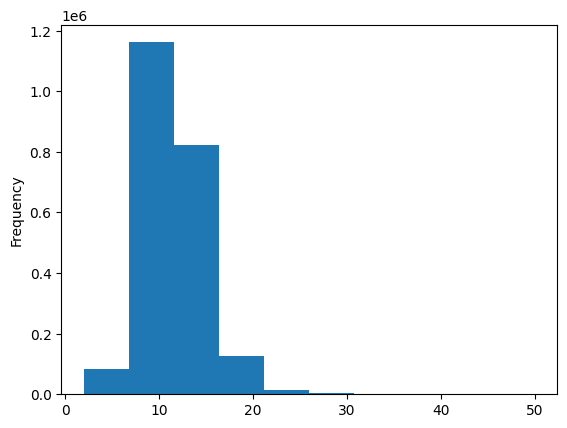

In [ ]:
# Check the length of different lines
train_df["total_lines"].plot.hist()

In [ ]:
# Convert abstract text lines into lists
train_sentences = train_df.text.tolist()
val_sentences = val_df.text.tolist()
test_sentences = test_df.text.tolist()

In [ ]:
train_sentences[:20]

['the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
 'this paper describes the design and evaluation of positive outlook , an online program aiming to enhance the self-management skills of gay men living with hiv .',
 'this study is designed as a randomised controlled trial in which men living with hiv in australia will be assigned to either an intervention group or usual care control group .',
 "the intervention group will participate in the online group program ` positive outlook ' .",
 'the program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with hiv in daily life .',
 'participants will access the program for a minimum of @ minutes per week over seven weeks .',
 'primary outcomes are domain sp

In [ ]:
len(train_sentences), len(val_sentences), len(test_sentences)

(2211861, 28932, 29493)

##1.3 Encoding labels

In [ ]:
# Using One Hot Encoder
ohe = OneHotEncoder(sparse=False)
train_labels_oh = ohe.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_oh = ohe.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_oh = ohe.transform(test_df["target"].to_numpy().reshape(-1,1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
classes = ohe.categories_[0]
classes

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [ ]:
train_df["target"].unique()

array(['BACKGROUND', 'METHODS', 'CONCLUSIONS', 'RESULTS', 'OBJECTIVE'],
      dtype=object)

In [ ]:
train_labels_oh[:5]

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [ ]:
# Using Label Encoder
lb = LabelEncoder()
train_labels = lb.fit_transform(train_df["target"].to_numpy())
val_labels = lb.transform(val_df["target"].to_numpy())
test_labels = lb.transform(test_df["target"].to_numpy())

In [ ]:
train_df["target"]

0          BACKGROUND
1          BACKGROUND
2             METHODS
3             METHODS
4             METHODS
              ...    
2211856       METHODS
2211857       METHODS
2211858       RESULTS
2211859       RESULTS
2211860       RESULTS
Name: target, Length: 2211861, dtype: object

In [ ]:
train_labels.shape

(2211861,)

In [ ]:
print(train_labels)
print(train_labels.shape)

[0 0 2 ... 4 4 4]
(2211861,)


In [ ]:
# Assign common name
X_train = train_sentences
y_train = train_labels
X_val = val_sentences
y_val = val_labels
X_test = train_sentences
y_test = test_labels

#2. Build model

##2.1 Model 0: MultinomialNB (baseline model)

In [ ]:
# Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])
# Fit the pipeline to training data
model_0.fit(X_train, y_train)

In [ ]:
# Evaluate with validation data
model_0.score(X_val, y_val)

In [ ]:
# Make prediction
y_pred = model_0.predict(X_val)
y_pred

In [ ]:
 def calculate_results(y_true, y_pred):

   # Calculate model accuracy
   model_accuracy = accuracy_score(y_true, y_pred)
   # Calculate model precision, recall, f1 score
   model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
   model_results = {"accuracy": model_accuracy,
                    "precision": model_precision,
                    "recall": model_recall,
                    "f1-score": model_f1}

   return model_results

In [ ]:
baseline_results = calculate_results(y_true=y_val,
                                     y_pred=y_pred)
baseline_results

##2.2 Model 1: Conv1D with token embeddings

###2.2.1 Create the token embeddings

In [ ]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_lens = np.mean(sent_lens)
print(sent_lens[:10])
print(avg_sent_lens)

[36, 27, 31, 15, 31, 17, 19, 25, 25, 26]
26.229355280462922


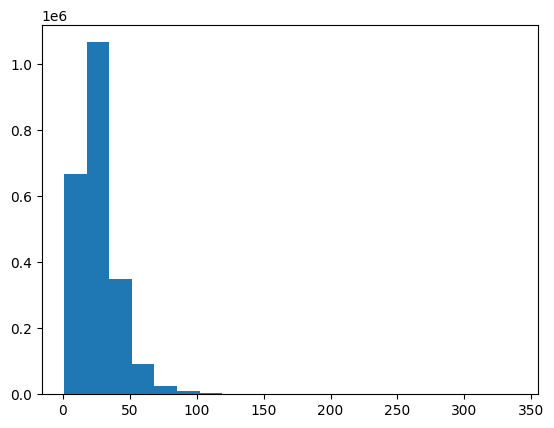

In [ ]:
plt.hist(sent_lens, bins=20);

In [ ]:
# Find the maximum of sentence length covering 95% of samples
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

54

In [ ]:
# Get the max token from the paper https://arxiv.org/pdf/1710.06071.pdf
max_tokens = 250000

In [ ]:
# Create text vectorizer
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_seq_len)

In [ ]:
# Adapt text vectorizer to training sentences
train_size = int(0.6*len(train_sentences))
train_samples = train_sentences[:train_size]
text_vectorizer.adapt(train_samples)

In [ ]:
token_vocab = text_vectorizer.get_vocabulary()
print(len(token_vocab)) 
print(token_vocab[:10])
print(token_vocab[-10:])

186308
['', '[UNK]', 'the', 'of', 'and', 'in', 'to', 'with', 'a', 'were']
['aacontaining', 'aachener', 'aacc', 'aabased', 'aaat', 'aaasurgery', 'aaaspecific', 'aaalanon', 'aaacp', 'aaaanalog']


In [ ]:
random.seed(77)
target_sent = random.choice(train_sentences)
print(target_sent)
print(len(target_sent.split()))

the incidence of variceal bleeding for the es and control group was @ % and @ % at @ year and @ % and @ % at @ years , respectively .
32


In [ ]:
vectorized_sent = text_vectorizer([target_sent])
vectorized_sent

<tf.Tensor: shape=(1, 54), dtype=int64, numpy=
array([[   2,  202,    3, 4260,  413,   12,    2, 2841,    4,   38,   13,
          10,    4,   16,  156,    4,    4,   16,   64,   74,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])>

In [ ]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(token_vocab),
                               output_dim=128,
                               mask_zero=True)

In [ ]:
embedded_sent = token_embed(vectorized_sent)
print(embedded_sent.shape)
print(embedded_sent)

(1, 54, 128)
tf.Tensor(
[[[ 0.04908395  0.01657974 -0.02273843 ...  0.04277274 -0.03694715
    0.02346021]
  [ 0.00701515  0.01102127  0.00423913 ...  0.03372821  0.00927798
    0.02132342]
  [-0.02354056 -0.02690263 -0.02039653 ... -0.02386906 -0.03346436
    0.04306263]
  ...
  [-0.00811043  0.04900746  0.00241108 ... -0.0354957   0.04844738
    0.04463387]
  [-0.00811043  0.04900746  0.00241108 ... -0.0354957   0.04844738
    0.04463387]
  [-0.00811043  0.04900746  0.00241108 ... -0.0354957   0.04844738
    0.04463387]]], shape=(1, 54, 128), dtype=float32)


In [ ]:
def create_token_dataset(sentences, labels, batch_size):
  dataset = tf.data.Dataset.from_tensor_slices((sentences, labels)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

  return dataset

In [ ]:
# Turn our data into tf datasets
BATCH_SIZE = 32
train_dataset = create_token_dataset(sentences=train_sentences, labels=train_labels_oh, batch_size=BATCH_SIZE)
val_dataset = create_token_dataset(sentences=val_sentences, labels=val_labels_oh, batch_size=BATCH_SIZE)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

###2.2.2 Create a model

In [ ]:
INPUT_SHAPE = (1,)
OUTPUT_SHAPE = 5

In [ ]:
inputs = Input(shape=INPUT_SHAPE, dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = GlobalMaxPooling1D()(x)
outputs = Dense(OUTPUT_SHAPE, activation="softmax")(x)
model_1 = Model(inputs, outputs)

In [ ]:
# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=Adam(),
                metrics = ["accuracy"])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 55, 128)           8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
# Fit the model
EPOCHS = 5
hist_1 = model_1.fit(train_dataset, epochs = EPOCHS, steps_per_epoch=int(0.1*len(train_dataset)),
                     validation_data=val_dataset, validation_steps=int(0.1*len(val_dataset)))

Epoch 1/5
562/562 [==============================] - 47s 64ms/step - loss: 0.8418 - accuracy: 0.6816 - val_loss: 0.5907 - val_accuracy: 0.7816
Epoch 2/5
562/562 [==============================] - 7s 13ms/step - loss: 0.5808 - accuracy: 0.7864 - val_loss: 0.5419 - val_accuracy: 0.7969
Epoch 3/5
562/562 [==============================] - 6s 11ms/step - loss: 0.5460 - accuracy: 0.7999 - val_loss: 0.5212 - val_accuracy: 0.8105
Epoch 4/5
562/562 [==============================] - 4s 7ms/step - loss: 0.5249 - accuracy: 0.8080 - val_loss: 0.5151 - val_accuracy: 0.8088
Epoch 5/5
562/562 [==============================] - 6s 11ms/step - loss: 0.5294 - accuracy: 0.8075 - val_loss: 0.4941 - val_accuracy: 0.8228


In [ ]:
# Make predicitons
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs.shape, model_1_pred_probs

945/945 [==============================] - 3s 3ms/step


((30212, 5),
 array([[5.2226859e-01, 2.4168301e-01, 1.3624306e-03, 2.2804917e-01,
         6.6368673e-03],
        [5.3326100e-01, 3.5680261e-01, 5.6769475e-03, 8.0539860e-02,
         2.3719573e-02],
        [1.4097455e-01, 3.4738906e-02, 7.7915136e-03, 8.1597000e-01,
         5.2508875e-04],
        ...,
        [7.3430978e-04, 1.6962553e-03, 1.2394770e-02, 2.4261451e-04,
         9.8493201e-01],
        [1.0664653e-02, 5.5456084e-01, 3.3159364e-02, 5.7125990e-03,
         3.9590245e-01],
        [4.8314329e-02, 9.3353122e-01, 8.7917615e-03, 3.9701946e-03,
         5.3924145e-03]], dtype=float32))

In [ ]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
model_1_results = calculate_results(val_labels, model_1_preds)
model_1_results

{'accuracy': 0.8210975771216735,
 'precision': 0.8227700550409679,
 'recall': 0.8210975771216735,
 'f1-score': 0.8187352948551208}

##2.3 Model 2: Using Feature extraction with pretrained token embeddings

In [ ]:
MODEL = "https://tfhub.dev/google/universal-sentence-encoder/4"
tf_hub_embedding_layer = hub.KerasLayer(MODEL, trainable=False)

In [ ]:
# Test the model
random.seed(66)
random_sent = random.choice(train_sentences)
random_sent

'predictors for @ ( oh ) d were intake of vitamin d , eicosapentaenoic acids ( epa ) , docosahexaenoic acids ( dha ) , vitamin d supplement , plasma epa and plasma dha .'

In [ ]:
emb_sent = tf_hub_embedding_layer([random_sent])
print(emb_sent.shape)
print(emb_sent)

(1, 512)
tf.Tensor(
[[ 1.93553697e-02 -2.25422308e-02 -6.16349876e-02 -4.76064049e-02
   8.05169065e-03 -2.68093478e-02  2.88273431e-02 -1.84032805e-02
  -3.94975357e-02 -4.04382218e-03  7.04939887e-02 -1.99950803e-02
  -6.03553765e-02  1.76249091e-02 -6.78505227e-02 -6.38464764e-02
  -7.10263997e-02 -5.45488782e-02  6.27603233e-02  4.98322910e-03
  -4.61170003e-02 -5.84955923e-02 -5.02432398e-02  6.02832548e-02
   4.42674942e-02 -2.29931008e-02  6.78203031e-02 -6.44782931e-02
   1.17496196e-02  2.07205620e-02 -3.04877739e-02  7.10608661e-02
   5.22035435e-02 -7.04922378e-02 -6.72184303e-02 -9.57696699e-03
   4.34730202e-02 -2.76727900e-02  1.48939239e-02  3.22517939e-02
   6.58591762e-02  6.97717890e-02  2.57945415e-02  5.37854573e-03
   5.02500124e-02 -5.54053448e-02 -5.00182509e-02 -4.46328297e-02
   4.83350782e-03  5.74679039e-02 -4.30706106e-02 -5.88729791e-02
  -2.22078077e-02  4.18582372e-02  6.90527484e-02  3.77562717e-02
  -2.12864615e-02 -4.57637291e-03  2.77748145e-02  3.368

In [ ]:
# Build model using TF Hub layer
inputs = Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = Dense(128, activation="relu")(pretrained_embedding)
outputs = Dense(OUTPUT_SHAPE, activation="softmax")(x)
model_2 = Model(inputs, outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit the model
EPOCHS = 3
hist_2 = model_2.fit(train_dataset, epochs = EPOCHS, steps_per_epoch=int(0.1*len(train_dataset)),
                     validation_data=val_dataset, validation_steps=int(0.1*len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 10s 14ms/step - loss: 0.9193 - accuracy: 0.6467 - val_loss: 0.7969 - val_accuracy: 0.6878
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7720 - accuracy: 0.7007 - val_loss: 0.7562 - val_accuracy: 0.7048
Epoch 3/3
562/562 [==============================] - 9s 16ms/step - loss: 0.7574 - accuracy: 0.7090 - val_loss: 0.7429 - val_accuracy: 0.7101


In [ ]:
# Make predicitons
model_2_pred_probs = model_2.predict(val_dataset)
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_results = calculate_results(val_labels, model_2_preds)
model_2_results

945/945 [==============================] - 12s 12ms/step


{'accuracy': 0.7117701575532901,
 'precision': 0.7118816954081416,
 'recall': 0.7117701575532901,
 'f1-score': 0.7088543939938126}

##2.3 Model 3: Conv1D with character embeddings

###2.3.1 Create the character embeddings

In [ ]:
# Create a function split sentences into a characters
def split_chars(text):
  return " ".join(list(text))

In [ ]:
random.seed(66)
random_sent = random.choice(train_sentences)
random_sent
split_chars(random_sent) 

's o m a t i c - t y p e   s y m p t o m s   (   i . e .   p a i n   ,   h e a v i n e s s   ,   s w e l l i n g   ,   u n a t t r a c t i v e   l e g s   )   w e r e   p r e s e n t   i n   t w o   ,   p s y c h i c - t y p e   s y m p t o m s   (   i . e .   l e g   -   a n d   p e r s o n a l i t y - r e l a t e d   u n r e s t   a n d   s t r e s s   )   i n   @   a n d   b o t h   c o m p o n e n t s   i n   s e v e n   o f   t h e   @   s u b j e c t s   .'

In [ ]:
# Turn our data into character-level data
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
len(train_chars), len(val_chars), len(test_chars)

(2211861, 28932, 29493)

In [ ]:
# Calculate average of character length 
train_char_lens = [len(sentence) for sentence in train_sentences]
np.mean(train_char_lens)

147.82646377869133

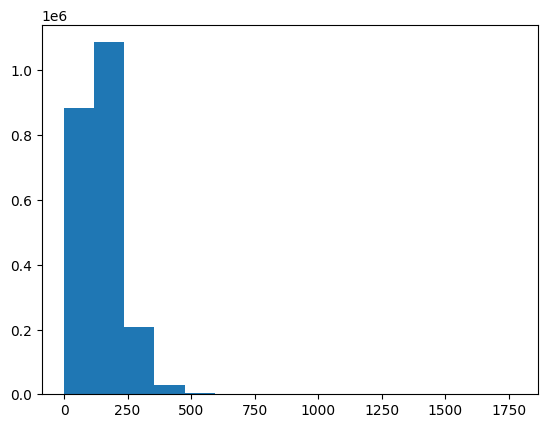

In [ ]:
plt.hist(train_char_lens, bins = 15);

In [ ]:
output_seq_char_len = int(np.percentile(train_char_lens, 95))
output_seq_char_len

284

In [ ]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create a character vecterizer
NUM_CHAR_TOKENS = len(alphabet) + 2 # for space and ['UKN']
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len
                                    )

In [ ]:
# Adapt character vecterizer for training data
train_char_size = int(0.4*len(train_sentences))
train_char_samples = train_sentences[:train_char_size]
char_vectorizer.adapt(train_char_samples)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
print(char_vocab)

['', '[UNK]', 'the', 'of', 'and', 'in', 'to', 'with', 'a', 'were', 'was', 'patients', 'for', 'group', 'p', 'or', 'at', 'treatment', 'on', 'study', 'after', 'by', 'is', 'groups', 'this', 'as', 'that', 'not', 'no', 'from', 'an', 'randomized', 'between', 'significant', 'significantly', 'compared', 'than', 'placebo', 'control', 'be', 'n', 'trial', 'months', 'mg', 'during', 'two', 'had', 'both', 'clinical', 'mean', 'vs', 'there', 'therapy', 'baseline', 'we', 'weeks', 'all', 'intervention', 'effects', 'more', 'time', 'pain', 'who', 'effect', 'years', 'but', 'are', 'using', 'rate', 'days']


In [ ]:
random_train_char = random.choice(train_chars)
char_vectorizer(random_train_char), len(char_vectorizer(random_train_char))

(<tf.Tensor: shape=(284,), dtype=int64, numpy=
 array([ 1,  1,  8, 40,  1, 40,  1,  1,  1,  1, 40,  1,  8,  1,  1,  1,  1,
         1,  1,  1, 40,  1,  1,  1,  1,  1,  1,  1,  1,  1, 14,  1,  1,  1,
        40,  1, 40,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  8,  1,  1,
         1,  1,  1,  8,  1,  1,  8, 40,  1,  1,  1,  1,  1,  8,  1,  1,  1,
         1, 40,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1, 40,  1,  8,  1,  1,  1,  1,  8, 40,  8,  1,  1,  1,  1,
         1,  1,  1, 14,  1,  8,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  

In [ ]:
# Create a character embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab),
                               output_dim=25,
                               mask_zero=True)

In [ ]:
char_embed_example = char_embed(char_vectorizer([random_train_char]))
char_embed_example.shape, char_embed_example

(TensorShape([1, 284, 25]),
 <tf.Tensor: shape=(1, 284, 25), dtype=float32, numpy=
 array([[[ 0.02107743, -0.03810956, -0.01610051, ...,  0.02415358,
           0.02659282,  0.04160645],
         [ 0.02107743, -0.03810956, -0.01610051, ...,  0.02415358,
           0.02659282,  0.04160645],
         [-0.01288788,  0.02787746, -0.0081826 , ..., -0.00024718,
           0.03833826,  0.02730315],
         ...,
         [ 0.04013929,  0.01107813,  0.0169828 , ...,  0.04829339,
           0.03702415, -0.03775672],
         [ 0.04013929,  0.01107813,  0.0169828 , ...,  0.04829339,
           0.03702415, -0.03775672],
         [ 0.04013929,  0.01107813,  0.0169828 , ...,  0.04829339,
           0.03702415, -0.03775672]]], dtype=float32)>)

In [ ]:
# Create a functiom to create a character dataset
def create_char_dataset(chars, labels, batch_size):
  dataset = tf.data.Dataset.from_tensor_slices((chars, labels)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

  return dataset

In [ ]:
# Create the character datasets
BATCH_SIZE = 32
train_char_dataset = create_char_dataset(chars=train_chars, labels=train_labels_oh, batch_size=BATCH_SIZE)
val_char_dataset = create_char_dataset(chars=val_chars, labels=val_labels_oh, batch_size=BATCH_SIZE)
len(train_char_dataset), len(val_char_dataset)

(5627, 945)

In [ ]:
# # Create the character datasets
# train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_oh)).batch(32).prefetch(tf.data.AUTOTUNE)
# val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_oh)).batch(32).prefetch(tf.data.AUTOTUNE)
# test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_oh)).batch(32).prefetch(tf.data.AUTOTUNE)
# len(train_char_dataset), len(val_char_dataset), len(test_char_dataset)

(5627, 945, 942)

In [ ]:
train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

###2.3.2 Build a model

In [ ]:
INPUT_SHAPE = (1,)
OUTPUT_SHAPE = 5
inputs = layers.Input(shape=INPUT_SHAPE, dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = GlobalMaxPooling1D()(x)
outputs = Dense(OUTPUT_SHAPE, activation="softmax")(x)
model_3 = Model(inputs, outputs)

# Compile the model
model_3.compile(loss = "categorical_crossentropy",
                optimizer = Adam(),
                metrics = ["accuracy"])          

model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 290)              0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 5)                 325 

In [ ]:
EPOCHS = 5
hist_3 = model_3.fit(train_char_dataset, steps_per_epoch=int(0.1*len(train_char_dataset)), epochs = EPOCHS,
                     validation_data=val_char_dataset, validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/5
562/562 [==============================] - 6s 8ms/step - loss: 1.2444 - accuracy: 0.4907 - val_loss: 1.0429 - val_accuracy: 0.5738
Epoch 2/5
562/562 [==============================] - 3s 5ms/step - loss: 1.0120 - accuracy: 0.5950 - val_loss: 0.9457 - val_accuracy: 0.6300
Epoch 3/5
562/562 [==============================] - 3s 5ms/step - loss: 0.9304 - accuracy: 0.6331 - val_loss: 0.8681 - val_accuracy: 0.6712
Epoch 4/5
562/562 [==============================] - 3s 5ms/step - loss: 0.8736 - accuracy: 0.6617 - val_loss: 0.8371 - val_accuracy: 0.6789
Epoch 5/5
562/562 [==============================] - 4s 6ms/step - loss: 0.8533 - accuracy: 0.6669 - val_loss: 0.8100 - val_accuracy: 0.6938


In [ ]:
# Make predicitons
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_results = calculate_results(val_labels, model_3_preds)
model_3_results

945/945 [==============================] - 2s 2ms/step


{'accuracy': 0.6792665166159142,
 'precision': 0.6844614153677404,
 'recall': 0.6792665166159142,
 'f1-score': 0.6753520847073154}

##2.4 Model 4: Combining pretrained token embeddings + characters embeddings

In [ ]:
# Setup a token model
OUTPUT_SHAPE = 5
token_inputs = Input(shape=[], dtype=tf.string)
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = Dense(128, activation="relu")(token_embeddings)
token_model = Model(token_inputs, token_outputs)

# Setup character model
char_inputs = Input(shape=(1), dtype=tf.string)
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = Model(char_inputs, char_bi_lstm)

# Concatenate token and char models
token_char_concat = Concatenate(name="token_char_model")([token_model.output, char_model.output])

# Adding Dropout layer and output layer
x = Dropout(0.5)(token_char_concat)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(OUTPUT_SHAPE, activation="softmax")(x)

model_4 = Model(inputs=[token_model.input, char_model.input],
                outputs=outputs)

In [ ]:
model_4.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 290)         0           ['input_5[0][0]']                
 orization)                                                                                       
                                                                                                  
 keras_layer (KerasLayer)       (None, 512)          256797824   ['input_4[0][0]']          

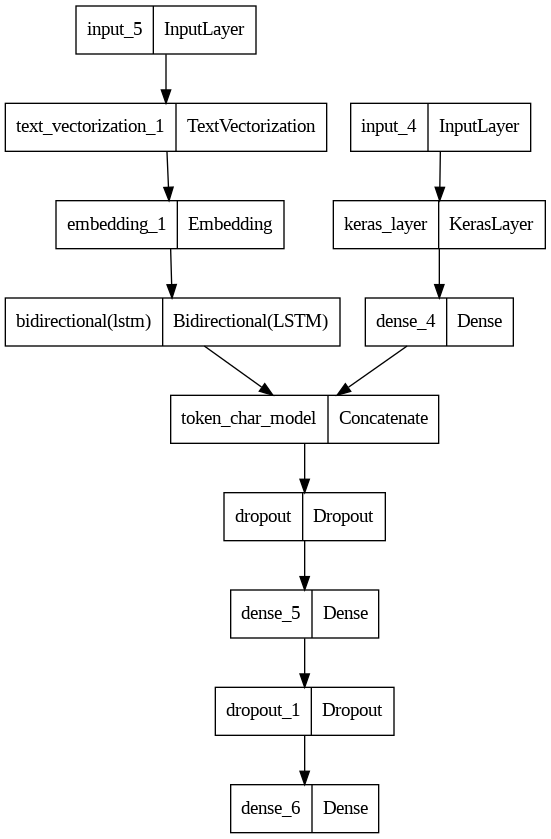

In [ ]:
# Plot model
plot_model(model_4)

In [ ]:
# Compile the model
model_4.compile(loss = "categorical_crossentropy",
                optimizer = Adam(),
                metrics = ["accuracy"])   

In [ ]:
# Create a function to get char-token dataset
def create_char_token_dataset(sentences, chars, labels, batch_size):
  char_token_data = tf.data.Dataset.from_tensor_slices((sentences, chars))
  char_token_labels = tf.data.Dataset.from_tensor_slices(labels)
  char_token_dataset = tf.data.Dataset.zip((char_token_data, char_token_labels)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

  return char_token_dataset

In [ ]:
# Create the char-token datasets
BATCH_SIZE = 32
train_char_token_dataset = create_char_token_dataset(sentences=train_sentences, chars=train_chars, labels=train_labels_oh, batch_size=BATCH_SIZE)
val_char_token_dataset = create_char_token_dataset(sentences=val_sentences, chars=val_chars, labels=val_labels_oh, batch_size=BATCH_SIZE)

In [ ]:
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# # Create the datasets
# train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
# train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_oh)
# train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

# val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
# val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_oh)
# val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Fit model
EPOCHS = 4
hist_4 = model_4.fit(train_char_token_dataset, epochs = EPOCHS, steps_per_epoch=int(0.2*len(train_char_token_dataset)),
                     validation_data=val_char_token_dataset, validation_steps=int(0.2*len(val_char_token_dataset)))

Epoch 1/4
1125/1125 [==============================] - 70s 52ms/step - loss: 0.8869 - accuracy: 0.6532 - val_loss: 0.7179 - val_accuracy: 0.7260
Epoch 2/4
1125/1125 [==============================] - 56s 49ms/step - loss: 0.7574 - accuracy: 0.7141 - val_loss: 0.6708 - val_accuracy: 0.7500
Epoch 3/4
1125/1125 [==============================] - 55s 49ms/step - loss: 0.7415 - accuracy: 0.7195 - val_loss: 0.6426 - val_accuracy: 0.7566
Epoch 4/4
1125/1125 [==============================] - 58s 52ms/step - loss: 0.7047 - accuracy: 0.7343 - val_loss: 0.6271 - val_accuracy: 0.7639


In [ ]:
# Make predicitons
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

945/945 [==============================] - 22s 20ms/step


{'accuracy': 0.7613200052959089,
 'precision': 0.7582691535752631,
 'recall': 0.7613200052959089,
 'f1-score': 0.7571185963557757}

##2.5 Model_5: Tranfer learning with pretrained token embeddings + character embeddings + positional embeddings

###2.5.1 Create positional embeddings

In [ ]:
train_df[:10]

,line_number,target,text,total_lines
0,0,BACKGROUND,the emergence of hiv as a chronic condition me...,10
1,1,BACKGROUND,this paper describes the design and evaluation...,10
2,2,METHODS,this study is designed as a randomised control...,10
3,3,METHODS,the intervention group will participate in the...,10
4,4,METHODS,the program is based on self-efficacy theory a...,10
5,5,METHODS,participants will access the program for a min...,10
6,6,METHODS,primary outcomes are domain specific self-effi...,10
7,7,METHODS,"secondary outcomes include : depression , anxi...",10
8,8,METHODS,"data collection will take place at baseline , ...",10
9,9,CONCLUSIONS,results of the positive outlook study will pro...,10


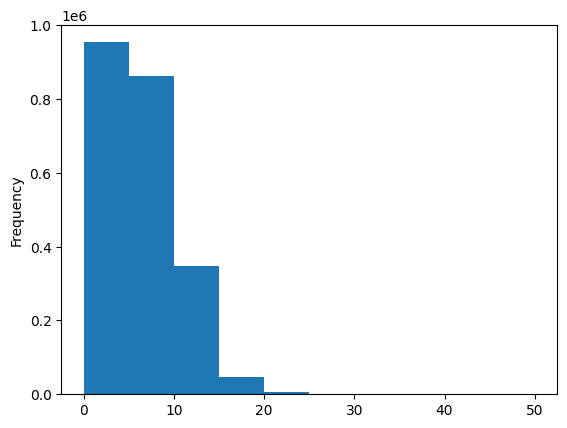

In [ ]:
train_df["line_number"].plot.hist();

In [ ]:
train_df["line_number"].value_counts()

0     190654
1     190654
2     190654
3     190644
4     190357
5     189080
6     185551
7     177967
8     164187
9     143835
10    117871
11     90168
12     64864
13     44350
14     29186
15     18785
16     11803
17      7392
18      4688
19      3030
20      1925
21      1268
22       814
23       564
24       398
25       288
26       214
27       159
28       118
29        88
30        64
31        55
32        42
33        34
34        21
35        17
36        12
37         9
40         6
38         6
39         6
41         5
42         5
43         5
44         4
45         4
46         3
47         2
48         2
49         2
50         1
Name: line_number, dtype: int64

In [ ]:
# Create one-hot-encoded tensors of line-number by TF
train_line_number_oh = tf.one_hot(train_df["line_number"].to_numpy(), depth=35)
val_line_number_oh = tf.one_hot(val_df["line_number"].to_numpy(), depth=35)
test_line_number_oh = tf.one_hot(test_df["line_number"].to_numpy(), depth=35)
train_line_number_oh

<tf.Tensor: shape=(2211861, 35), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

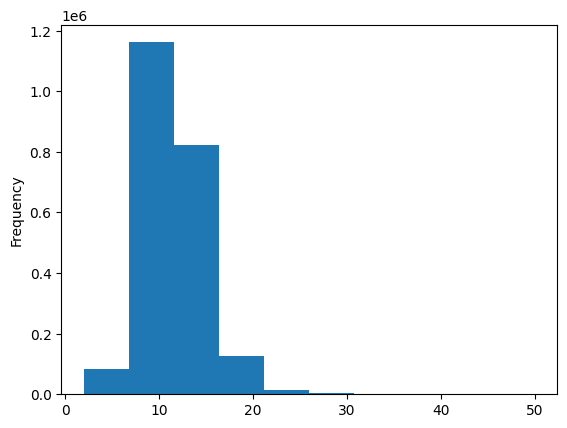

In [ ]:
train_df["total_lines"].plot.hist();

In [ ]:
np.percentile(train_df["total_lines"], 98)

20.0

In [ ]:
# Create one-hot-encoded tensors of total_line by TF
train_total_lines_oh = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_oh = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_oh = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
train_total_lines_oh

<tf.Tensor: shape=(2211861, 20), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [ ]:
# Create a function to get char-token-position dataset
BATCH_SIZE = 32
def create_char_token_pos_dataset(line_number_oh, total_lines_oh, sentences, chars, labels, batch_size):
  char_token_pos_data = tf.data.Dataset.from_tensor_slices((line_number_oh, 
                                                            total_lines_oh, 
                                                            sentences, 
                                                            chars))
  char_token_pos_labels = tf.data.Dataset.from_tensor_slices(labels)
  char_token_pos_dataset = tf.data.Dataset.zip((char_token_pos_data, char_token_pos_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

  return char_token_pos_dataset

In [ ]:
train_char_token_pos_dataset = create_char_token_pos_dataset(line_number_oh=train_line_number_oh, 
                                                             total_lines_oh=train_total_lines_oh, 
                                                             sentences=train_sentences, 
                                                             chars=train_chars, 
                                                             labels=train_labels_oh, 
                                                             batch_size=BATCH_SIZE)
val_char_token_pos_dataset = create_char_token_pos_dataset(line_number_oh=val_line_number_oh, 
                                                           total_lines_oh=val_total_lines_oh, 
                                                           sentences=val_sentences, 
                                                           chars=val_chars, 
                                                           labels=val_labels_oh, 
                                                           batch_size=BATCH_SIZE)
test_char_token_pos_dataset = create_char_token_pos_dataset(line_number_oh=test_line_number_oh, 
                                                           total_lines_oh=test_total_lines_oh, 
                                                           sentences=test_sentences, 
                                                           chars=test_chars, 
                                                           labels=test_labels_oh, 
                                                           batch_size=BATCH_SIZE)

In [ ]:
train_char_token_pos_dataset.element_spec

((TensorSpec(shape=(None, 35), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 20), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.string, name=None),
  TensorSpec(shape=(None,), dtype=tf.string, name=None)),
 TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))

###2.5.1 Combine all of those things into a model

In [ ]:
OUTPUT_SHAPE = 5
# Setup a token model
MODEL = "https://tfhub.dev/google/universal-sentence-encoder/4"
tf_hub_embedding_layer = hub.KerasLayer(MODEL, trainable=False)
token_inputs = Input(shape=[], dtype=tf.string, name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = Dense(128, activation="relu")(token_embeddings)
token_model = Model(inputs=token_inputs,
                    outputs=token_outputs)

# Setup character model
char_inputs = Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = Model(inputs=char_inputs, 
                   outputs=char_bi_lstm)

# Setup line number model
line_number_inputs = Input(shape=(35,), dtype=tf.float32, name="line_number_inputs")
x = Dense(32, activation="relu")(line_number_inputs)
line_number_model = Model(inputs=line_number_inputs, 
                          outputs=x)

# Setup totol line model
total_lines_inputs = Input(shape=(20,), dtype=tf.float32, name="total_line_inputs")
y = Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = Model(inputs=total_lines_inputs, 
                          outputs=y)

# Concatenate token and char models
combined_embeddings = Concatenate(name="char_token_embeddings")([token_model.output,
                                     char_model.output])

# Add some Dense and Dropout layers
z = Dense(256, activation="relu")(combined_embeddings)
dropout = Dropout(0.5)(z)

# Concatenate combined_embeddings with positinal embeddings
final_embeddings = Concatenate(name="char_token_positional_embeddings")([line_number_model.output,
                                 total_lines_model.output,
                                 dropout])

# Create output layer
output_layer = Dense(OUTPUT_SHAPE, activation="softmax", name="output_layer")(final_embeddings)

# Creat a model
model_5 = Model(inputs=[line_number_model.input,
                        total_lines_model.input,
                        token_model.input,
                        char_model.input],
                outputs=output_layer)

model_5.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 284)         0           ['char_inputs[0][0]']            
 orization)                                                                                       
                                                                                                  
 keras_layer (KerasLayer)       (None, 512)          256797824   ['token_inputs[0][0]']     

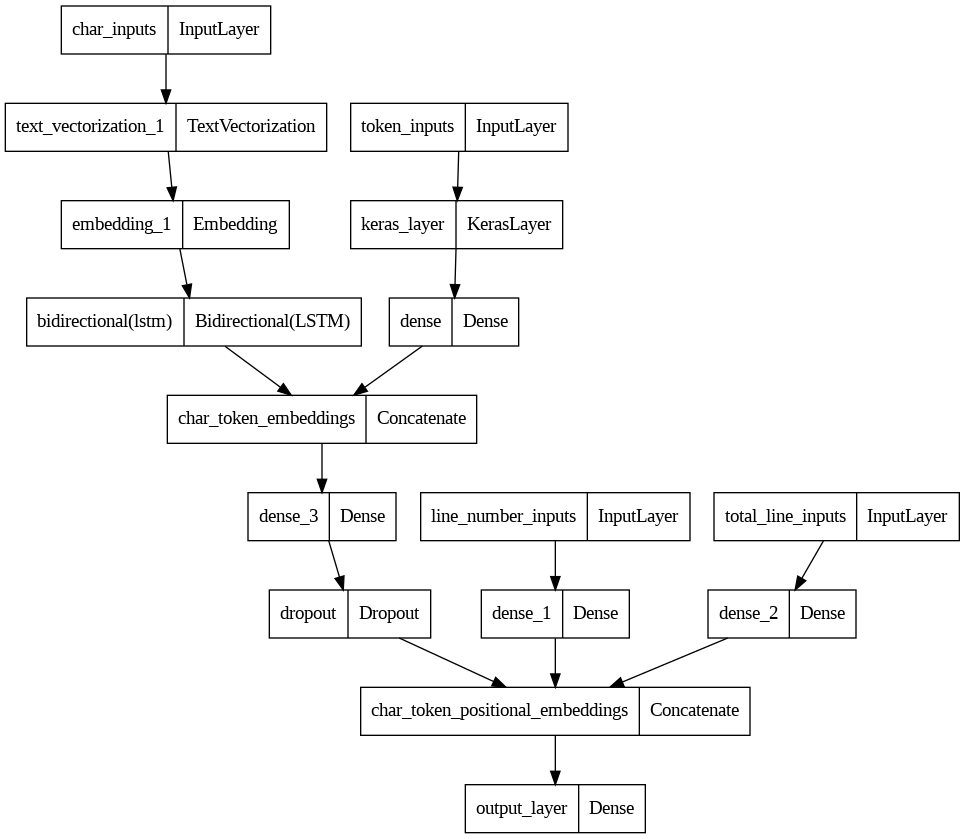

In [ ]:
plot_model(model_5)

In [ ]:
# compile the final model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # hepls to prevent overfiting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
%%time
EPOCHS = 3
hist_5 = model_5.fit(train_char_token_pos_dataset, 
                     steps_per_epoch=int(0.1*len(train_char_token_pos_dataset)), 
                     epochs=EPOCHS,
                     validation_data=val_char_token_pos_dataset,
                     validation_steps=int(0.1*len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 36s 63ms/step - loss: 1.0580 - accuracy: 0.7514 - val_loss: 0.9792 - val_accuracy: 0.8009
Epoch 2/3
562/562 [==============================] - 39s 70ms/step - loss: 0.9619 - accuracy: 0.8191 - val_loss: 0.9469 - val_accuracy: 0.8275
Epoch 3/3
562/562 [==============================] - 32s 57ms/step - loss: 0.9447 - accuracy: 0.8258 - val_loss: 0.9361 - val_accuracy: 0.8334
CPU times: user 2min 10s, sys: 8.17 s, total: 2min 18s
Wall time: 1min 46s


In [ ]:
# Make predicitons
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset)
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_results = calculate_results(val_labels, model_5_preds)
model_5_results

945/945 [==============================] - 24s 26ms/step


{'accuracy': 0.8362240169469085,
 'precision': 0.8347712245558687,
 'recall': 0.8362240169469085,
 'f1-score': 0.8350263444499741}

In [ ]:
# Compare model results
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_model_token_embedding": model_2_results,
                                  "model_3_custom_char_embedding": model_3_results,
                                  "model_4_char_token_embedding": model_4_results,
                                  "model_5_char_token_pos_embedding": model_5_results})
all_model_results = all_model_results.T
all_model_results

,accuracy,precision,recall,f1-score
model_0_baseline,0.721832,0.718647,0.721832,0.698925
model_1_custom_token_embedding,0.821098,0.822770,0.821098,0.818735
model_2_pretrained_model_token_embedding,0.711770,0.711882,0.711770,0.708854
model_3_custom_char_embedding,0.679267,0.684461,0.679267,0.675352
model_4_char_token_embedding,0.761320,0.758269,0.761320,0.757119
model_5_char_token_pos_embedding,0.846650,0.847097,0.846650,0.843805


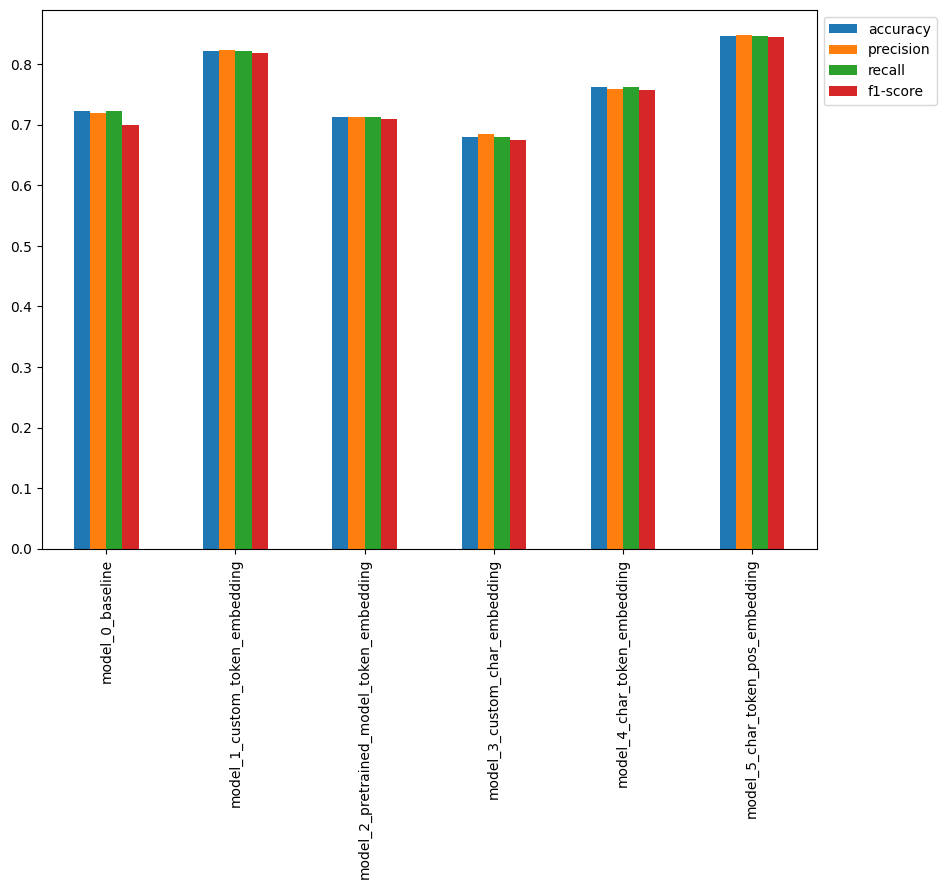

In [ ]:
  all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1, 1));

#3 Hypertuning






## We will choose the model 5 for tuning

##3.1 Create a Keras tuner

In [ ]:
train_char_token_pos_dataset, val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 25), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 25), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
MODEL = "https://tfhub.dev/google/universal-sentence-encoder/4"

In [ ]:
def build_model(hp):
  # Setup a token model
  tf_hub_embedding_layer = hub.KerasLayer(MODEL, trainable=False)
  token_inputs = Input(shape=[], dtype=tf.string, name="token_inputs")
  token_embeddings = tf_hub_embedding_layer(token_inputs)
  token_outputs = Dense(hp.Int("dense_units", min_value=32, max_value=160, step=32), activation="relu")(token_embeddings)
  token_model = Model(inputs=token_inputs,
                      outputs=token_outputs)

  # Setup character model
  char_inputs = Input(shape=(1,), dtype=tf.string, name="char_inputs")
  char_vectors = char_vectorizer(char_inputs)
  char_embeddings = char_embed(char_vectors)
  char_bi_lstm = layers.Bidirectional(layers.LSTM(hp.Int("lstm_units", min_value=8, max_value=32, step=8)))(char_embeddings)
  char_model = Model(inputs=char_inputs, 
                    outputs=char_bi_lstm)

  # Setup line number model
  line_number_inputs = Input(shape=(25,), dtype=tf.float32, name="line_number_inputs")
  x = Dense(hp.Int("line_dense_units", min_value=16, max_value=64, step=16), activation="relu")(line_number_inputs)
  line_number_model = Model(inputs=line_number_inputs, 
                            outputs=x)

  # Setup totol line model
  total_lines_inputs = Input(shape=(20,), dtype=tf.float32, name="total_line_inputs")
  y = Dense(hp.Int("total_dense_units", min_value=16, max_value=64, step=16), activation="relu")(total_lines_inputs)
  total_lines_model = Model(inputs=total_lines_inputs, 
                            outputs=y)

  # Concatenate token and char models
  combined_embeddings = Concatenate(name="char_token_embeddings")([token_model.output,
                                      char_model.output])

  # Add some Dense and Dropout layers
  z = Dense(hp.Int("dense_units_2", min_value=64, max_value=256, step=32), activation="relu")(combined_embeddings)
  dropout = Dropout(hp.Float("dropout", min_value=0.2, max_value=0.5, step=0.1))(z)

  # Concatenate combined_embeddings with positinal embeddings
  final_embeddings = Concatenate(name="char_token_positional_embeddings")([line_number_model.output,
                                  total_lines_model.output,
                                  dropout])

  # Create output layer
  output_layer = Dense(5, activation="softmax", name="output_layer")(final_embeddings)

  # Creat a model
  model = Model(inputs=[line_number_model.input,
                        total_lines_model.input,
                        token_model.input,
                        char_model.input],
                outputs=output_layer)

  # Compile the model
  model.compile(loss="categorical_crossentropy",
                optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                metrics=["accuracy"])
  return model

In [ ]:
tuner = 0
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10)

In [ ]:
EPOCHS = 3
BATCH_SIZE = 32
results = tuner.search(train_char_token_pos_dataset.take(round(0.1*len(train_char_token_pos_dataset))), 
                       epochs=EPOCHS,
                       validation_data=val_char_token_pos_dataset.take(round(0.1*len(val_char_token_pos_dataset))))

In [ ]:
best_model = tuner.get_best_models()

In [ ]:
best_model

In [ ]:
for model in tuner.get_best_models(num_models=2):
    print(model.summary())


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 290)         0           ['char_inputs[0][0]']            
 orization)                                                                                       
                                                                                                  
 keras_layer (KerasLayer)       (None, 512)          256797824   ['token_inputs[0][0]']     

In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters()
best_hyperparameters

In [ ]:
for idx, model in enumerate(best_model):
    print(f"\nBest model {idx + 1} hyperparameters:")
    for hp_name, hp_value in best_hyperparameters[idx].values.items():
        print(f"{hp_name}: {hp_value}")


Best model 1 hyperparameters:
dense_units: 128
lstm_units: 8
line_dense_units: 64
total_dense_units: 64
dense_units_2: 256
dropout: 0.4
learning_rate: 0.001


##3.2 Pick the most hyperparameter for fitting full of dataset

In [ ]:
OUTPUT_SHAPE = 5
# Setup a token model
MODEL = "https://tfhub.dev/google/universal-sentence-encoder/4"
tf_hub_embedding_layer = hub.KerasLayer(MODEL, trainable=False)
token_inputs = Input(shape=[], dtype=tf.string, name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = Dense(128, activation="relu")(token_embeddings)
token_model = Model(inputs=token_inputs,
                    outputs=token_outputs)

# Setup character model
char_inputs = Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(8))(char_embeddings)
char_model = Model(inputs=char_inputs, 
                   outputs=char_bi_lstm)

# Setup line number model
line_number_inputs = Input(shape=(35,), dtype=tf.float32, name="line_number_inputs")
x = Dense(64, activation="relu")(line_number_inputs)
line_number_model = Model(inputs=line_number_inputs, 
                          outputs=x)

# Setup totol line model
total_lines_inputs = Input(shape=(20,), dtype=tf.float32, name="total_line_inputs")
y = Dense(64, activation="relu")(total_lines_inputs)
total_lines_model = Model(inputs=total_lines_inputs, 
                          outputs=y)

# Concatenate token and char models
combined_embeddings = Concatenate(name="char_token_embeddings")([token_model.output,
                                     char_model.output])

# Add some Dense and Dropout layers
z = Dense(256, activation="relu")(combined_embeddings)
dropout = Dropout(0.5)(z)

# Concatenate combined_embeddings with positinal embeddings
final_embeddings = Concatenate(name="char_token_positional_embeddings")([line_number_model.output,
                                 total_lines_model.output,
                                 dropout])

# Create output layer
output_layer = Dense(OUTPUT_SHAPE, activation="softmax", name="output_layer")(final_embeddings)

# Creat a model
model_5 = Model(inputs=[line_number_model.input,
                        total_lines_model.input,
                        token_model.input,
                        char_model.input],
                outputs=output_layer)


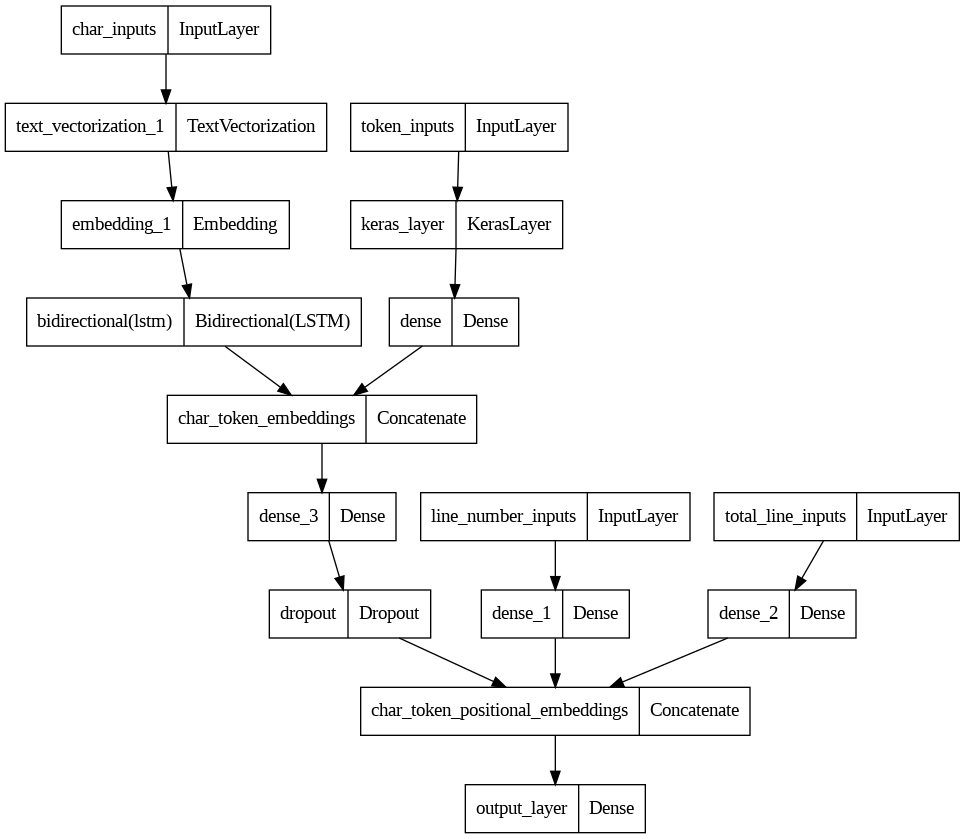

In [ ]:
plot_model(model_5)

In [ ]:
 # Compile the model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=Adam(learning_rate=0.01),
              metrics=["accuracy"])

In [ ]:
# Create a function to build a TensorBoard callback
def create_tensorboard():
  log_dir = os.path.join("/content/drive/MyDrive/SkimLit_NPL/pubmed-rct/logs", datetime.now().strftime("%y%m%d-%H%M%S"))

  return TensorBoard(log_dir)

In [ ]:
# Create Earlystopping callback
early_stopping = EarlyStopping(monitor="val_accuracy", patience=3)

In [ ]:
checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/SkimLit_NPL/pubmed-rct/checkpoints/2-weights.{epoch:02d}-{val_loss:.2f}',
    monitor='val_loss',
    verbose=1,
    save_best_only=False,
    save_weights_only=True,
    mode='auto',
    save_freq='epoch',
    save_format='tf')

In [ ]:
# Fit the model
%%time
EPOCHS = 10
hist_5 = model_5.fit(train_char_token_pos_dataset, 
                     epochs=EPOCHS,
                     validation_data=val_char_token_pos_dataset,
                     callbacks=[checkpoint_callback, early_stopping, create_tensorboard()])

Epoch 1/10
69121/69121 [==============================] - ETA: 0s - loss: 0.3240 - accuracy: 0.8791
Epoch 1: saving model to /content/drive/MyDrive/SkimLit_NPL/pubmed-rct/checkpoints/2-weights.01-0.30
69121/69121 [==============================] - 3489s 50ms/step - loss: 0.3240 - accuracy: 0.8791 - val_loss: 0.3045 - val_accuracy: 0.8860
Epoch 2/10
69120/69121 [============================>.] - ETA: 0s - loss: 0.3203 - accuracy: 0.8807
Epoch 2: saving model to /content/drive/MyDrive/SkimLit_NPL/pubmed-rct/checkpoints/2-weights.02-0.31
69121/69121 [==============================] - 3479s 50ms/step - loss: 0.3203 - accuracy: 0.8807 - val_loss: 0.3062 - val_accuracy: 0.8849
Epoch 3/10
69120/69121 [============================>.] - ETA: 0s - loss: 0.3187 - accuracy: 0.8814
Epoch 3: saving model to /content/drive/MyDrive/SkimLit_NPL/pubmed-rct/checkpoints/2-weights.03-0.31
69121/69121 [==============================] - 3412s 49ms/step - loss: 0.3187 - accuracy: 0.8814 - val_loss: 0.3053 - v

#4. Evaluate on test dataset

In [ ]:
def load_best_checkpoint(checkpoint_dir, metric='val_loss', mode='min'):
    # Get a list of all checkpoint files in the directory
    checkpoint_files = glob.glob(checkpoint_dir + "2-weights.*")

    # Sort the checkpoint files based on the metric value
    sorted_checkpoint = sorted(checkpoint_files, key=lambda x: float(x.split('-')[-1].split('.')[0]))

    # Select the best checkpoint file based on the metric and mode
    if mode == 'min':
      element = sorted_checkpoint[0]
      element_without_extension = os.path.splitext(element)[0]
      best_checkpoint_file = element_without_extension
    elif mode == 'max':
      element = sorted_checkpoint[-1]
      element_without_extension = os.path.splitext(element)[0]
      best_checkpoint_file = element_without_extension
    else:
      raise ValueError("Invalid mode. Must be 'min' or 'max'.")

    # Load the weights from the best checkpoint file
    model_5.load_weights(best_checkpoint_file)

    return model_5

In [ ]:
checkpoint_dir = "/content/drive/MyDrive/SkimLit_NPL/pubmed-rct/checkpoints/"
loaded_model = load_best_checkpoint(checkpoint_dir, metric='val_loss', mode='min')

In [ ]:
import keras
model_5 = keras.models.load_model("/content/drive/MyDrive/SkimLit_NPL/pubmed-rct/models/20230524-195239532098")
model_5.load_weights("/content/drive/MyDrive/SkimLit_NPL/pubmed-rct/checkpoints/2-weights.01-0.30")

In [ ]:
test_labels_oh

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
test_char_token_pos_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 35), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Make predicitons with test datasets
model_5_pred_probs = model_5.predict(test_char_token_pos_dataset)
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_results = calculate_results(test_labels, model_5_preds)
model_5_results

922/922 [==============================] - 24s 21ms/step


{'accuracy': 0.8840402807445834,
 'precision': 0.8855787236314059,
 'recall': 0.8840402807445834,
 'f1-score': 0.882550567428959}

In [ ]:
model_5_pred_probs = loaded_model.predict(test_char_token_pos_dataset)
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_results = calculate_results(test_labels, model_5_preds)
model_5_results

922/922 [==============================] - 19s 21ms/step


{'accuracy': 0.8840402807445834,
 'precision': 0.8855787236314059,
 'recall': 0.8840402807445834,
 'f1-score': 0.882550567428959}

#5 Save and load the model

##5.1 Save model

In [ ]:
!mkdir models

mkdir: cannot create directory ‘models’: File exists


In [ ]:
%cd /content/drive/MyDrive/SkimLit_NPL/pubmed-rct

/content/drive/MyDrive/SkimLit_NPL/pubmed-rct


In [ ]:
# Create a function to save a model
import os
from datetime import datetime
def save_model(model, save_dir="./models", save_format="tf"):
    
    # generate a timestamp for the model name
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S%f")
    
    # set the file extension based on the save format
    if save_format == "h5":
        file_ext = ".h5"
    elif save_format == "tf":
        file_ext = ""
    else:
        raise ValueError(f"Unsupported save format: {save_format}")
    
    # create the file path for the saved model
    file_path = os.path.join(save_dir, f"{timestamp}{file_ext}")
    
    # save the model
    model.save(file_path, save_format=save_format)
    
    # print the file path for reference
    print(f"Saved model to {file_path}")


In [ ]:
save_model(model_5)

Saved model to ./models/20230524-195239532098


##5.2 Load model

In [ ]:
!ls pubmed-rct/models

20230516-055852470025


In [ ]:
# Set the file path to the saved model
file_path = "/content/drive/MyDrive/SkimLit_NPL/pubmed-rct/models/20230516-055852470025"

# Load the model from TensorFlow format
loaded_model = tf.keras.models.load_model(file_path)

In [ ]:
# Make predicitons with test datasets
model_5_pred_probs = loaded_model.predict(test_char_token_pos_dataset)
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_results = calculate_results(test_labels, model_5_preds)
model_5_results

922/922 [==============================] - 17s 18ms/step


{'accuracy': 0.8840402807445834,
 'precision': 0.8855787236314059,
 'recall': 0.8840402807445834,
 'f1-score': 0.882550567428959}

##5.3 Creaeta a function to predict new instances
test_sentences[1]

In [ ]:
test_df

,line_number,target,text,total_lines
0,0,BACKGROUND,many pathogenic processes and diseases are the...,10
1,1,BACKGROUND,it was recently demonstrated that supraphysiol...,10
2,2,BACKGROUND,"in the present study , we examined the associa...",10
3,3,BACKGROUND,"in addition , we compared plasma levels of map...",10
4,4,METHODS,a total of @ mi patients and @ control persons...,10
...,...,...,...,...
29488,7,RESULTS,bone loss at the median forearm site was signi...,11
29489,8,RESULTS,breast tenderness occurred in @ percent of the...,11
29490,9,RESULTS,vaginal bleeding occurred at some time in @ pe...,11
29491,10,CONCLUSIONS,in postmenopausal women with low bone density ...,11


In [ ]:
model_5 = keras.models.load_model("/content/drive/MyDrive/SkimLit_NPL/pubmed-rct/models/20230524-195239532098")
model_5.load_weights("/content/drive/MyDrive/SkimLit_NPL/pubmed-rct/checkpoints/2-weights.01-0.30")

In [ ]:
def prepare_input(input_text):
  input_sentences = input_text.split(".")
  abstract_samples = []
  for abstract_line_number, abstract_line in enumerate(input_sentences):
    line_data = {}
    line_data["line_number"] = abstract_line_number
    line_data["text"] = abstract_line.lower()
    line_data["total_lines"] = len(input_sentences)
    abstract_samples.append(line_data)
  input_df = pd.DataFrame(abstract_samples)
  input_chars = [" ".join(list(sentence)) for sentence in input_sentences]
  input_line_number_oh = tf.one_hot(input_df["line_number"].to_numpy(), depth=35)
  input_total_lines_oh = tf.one_hot(input_df["total_lines"].to_numpy(), depth=20)
  
  # return char_token_pos_dataset
  return [input_line_number_oh.numpy(), input_total_lines_oh.numpy(), np.array(input_sentences), np.array(input_chars)]

In [ ]:
input_text = "The title should summarize the abstract and convince the reviewers that the topic is important, relevant, and innovative. To create a winning title, write out 6 to 10 key words found in the abstract and string them into various sentences. Once you have a sentence that adequately conveys the meaning of the work, try to condense the title yet still convey the essential message. Some organizations require a special format for the title, such as all uppercase letters, all bolded, or in italics. Be sure to check the instructions"

inputs = prepare_input(input_text)
predictions = model_5.predict(inputs)
print(predictions)

1/1 [==============================] - 0s 70ms/step
[[5.0706601e-01 3.2402463e-03 1.9441505e-03 4.8769897e-01 5.0514256e-05]
 [9.6052672e-06 3.0348193e-08 9.9966896e-01 1.4763894e-04 1.7377448e-04]
 [7.2840139e-02 1.2261264e-02 7.5679636e-01 4.4974308e-02 1.1312787e-01]
 [2.1578874e-02 2.2904674e-02 8.9166504e-01 5.4896157e-03 5.8361888e-02]
 [1.6787235e-02 1.6536580e-01 5.4152197e-01 2.1358670e-03 2.7418914e-01]]


In [ ]:
def prediction(input_text):
  classes = ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']
  input_text_split = input_text.split(".")
  index = np.argmax(predictions, axis=1)
  results = [classes[i] for i in index]
  new_order = ['OBJECTIVE', 'BACKGROUND', 'METHODS', 'RESULTS', 'CONCLUSIONS']
  for order_class in new_order:
    current_sentences = list()
    for idx, input_class in enumerate(results):
      if input_class == order_class:
        current_sentences.append(input_text_split[idx])
    current_sentences = '.'.join(current_sentences)
    print(f"{order_class}: {current_sentences}")
  return current_sentences

In [ ]:
prediction(input_text)

OBJECTIVE: 
BACKGROUND: The title should summarize the abstract and convince the reviewers that the topic is important, relevant, and innovative
METHODS:  To create a winning title, write out 6 to 10 key words found in the abstract and string them into various sentences. Once you have a sentence that adequately conveys the meaning of the work, try to condense the title yet still convey the essential message. Some organizations require a special format for the title, such as all uppercase letters, all bolded, or in italics. Be sure to check the instructions
RESULTS: 
CONCLUSIONS: 


''